# CAB420, Practical 5, Question 2 Template

## Data Augmentation. 

The Houses dataset contains about 500 sets of images of houses, and the corresponding price of those houses. There are a number of images for each house, with images covering the front, bathroom, kitchen and bedroom. Ordinarily, this would be too little data to train a deep neural network, however data augmentation offers one way to try to overcome this. Using this dataset, design and train a model to predict the house price from an image. In doing this you should:
* Design a simple network for this task, bearing in mind that you have limited data. While you may wish to fine-tune from a dataset such as CIFAR, note that this will restrict you to images of size 32 × 32 (unless you make larger changes to the network)
* Divide the dataset into appropriate training and testing splits.
* Set appropriate data augmentation parameters to generate additional samples.
* Train the network and evaluate it’s performance. You may also which to consider which images to use. Using all images obviously leads to more data, but also increases the problem space, while using only (for example) frontal images may make the task easier as the network only needs to learn information relative to the front of the house.

### Relevant Examples

The sixth DCNN example, ``CAB420_DCNNs_Example_6_Fine_Tuning_and_Data_Augmentation.ipynb`` is a good starting point, and deals with fine-tuning.

The two "Lots of" scripts, ``CAB420_DCNN_Models_Additional_Script_Lots_of_ResNet_Models.ipynb`` and ``CAB420_DCNN_Models_Additional_Script_Lots_of_VGG_Like_Models.ipynb`` produce lots of pre-trained models that you can use. Saved models that result for both of theses scripts are up on blackboard.

### Suggested Packages

Once again it's tensor flow and keras here. sklearn and matplotlib provide some supporting functionality.

In [75]:
import os
# why is this here? This is disabling some tensorflow warning I get in some of my environments that 
# annoy me (look ugly and untidy really)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import keras
from keras import layers

import tensorflow as tf

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

import scipy.io
import numpy

tf.config.optimizer.set_jit(False) #for jupyterlab only

### Step 1: Load and Prepare Data

#### Frontal Images Only, or use all images?

You can the images in different ways. Here, we provide code to load either the frontal data, or all data.

Comment out/delete the one that you don't wish to use. You can also change your training/testing split sizes as you wish.

In [76]:
houses_data = scipy.io.loadmat('houses_frontal.mat')
train = houses_data['images_frontal'][:,:,:,0:450]
train = numpy.transpose(train, (3, 0, 1, 2))
train_y = houses_data['costs_frontal'][0:450]
test = houses_data['images_frontal'][:,:,:,450:]
test = numpy.transpose(test, (3, 0, 1, 2))
test_y = houses_data['costs_frontal'][450:]

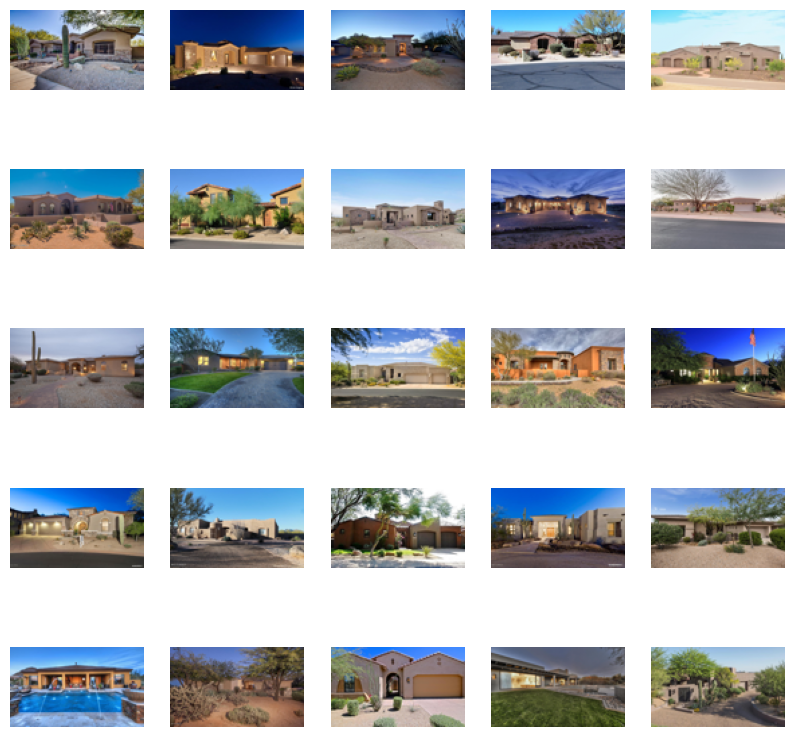

In [77]:
fig = plt.figure(figsize=[10, 10])
for i in range(25):
    ax = fig.add_subplot(5, 5, i + 1)
    ax.imshow(train[i,:,:,:])
    ax.axis('off')

In [78]:
#houses_data = scipy.io.loadmat('../../data/Houses/houses_all.mat')
#train = houses_data['images_all'][:,:,:,0:1800]
#train = numpy.transpose(train, (3, 0, 1, 2))
#train_y = houses_data['costs_all'][0:1800]
#test = houses_data['images_all'][:,:,:,1800:]
#test = numpy.transpose(test, (3, 0, 1, 2))
#test_y = houses_data['costs_all'][1800:]

You could use a tensorflow dataset object here if you wish

In [79]:
training_data = tf.data.Dataset.from_tensor_slices((train, train_y))
training_data = training_data.shuffle(1000)
# modify to your chosen batch size
training_data = training_data.batch(4)

### Step 2: The Network

Build your network here. Things you should consider here include:
* What size inputs do you have? How many layers/what size filters do you need for later layers to be able to see a large potion of the image (large receptive field)
  * By default, the images will be 100x60, but you can resize them.
  * Smaller images will mean you can process faster (and more easily build a deeper network), but you will lose fine grained information. There is a trade-off here that is interesting to explore. One other factor to add into this mix is that you can crop the images, i.e. crop out a smaller region and reduce the image size this way.  
* How powerful is your computer? If you are running on CPU, keep the network simple (fewer layers, lower numbers of filters)
* What is your network output? What size should the output be, and what loss should you be using?

In [80]:
def CreateModel():
    # input in an image shape - if you resize the images change the input shape
    inputs = keras.Input(shape=(60, 100, 3, ), name='img')

    # add you layers here
    x = layers.Conv2D(filters=8, kernel_size=(5,5), activation='swish', padding='same')(inputs)
    x = layers.Conv2D(filters=8, kernel_size=(5,5), activation=None, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('swish')(x)
    x = layers.MaxPool2D(pool_size=(2,2))(x)

    x = layers.Conv2D(filters=16, kernel_size=(3,3), activation='swish', padding='same')(x)
    x = layers.Conv2D(filters=16, kernel_size=(3,3), activation=None, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('swish')(x)
    x = layers.MaxPool2D(pool_size=(2,2))(x)
    
    x = layers.Conv2D(filters=32, kernel_size=(3,3), activation='swish', padding='same')(x)
    x = layers.Conv2D(filters=32, kernel_size=(3,3), activation=None, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('swish')(x)
    x = layers.MaxPool2D(pool_size=(2,2))(x)

    
    # create the output
    x = layers.Flatten()(x)
    x = layers.Dense(128, activation='swish')(x)
    outputs = layers.Dense(1, activation='relu')(x)

    # build and return the model
    model_cnn = keras.Model(inputs=inputs, outputs=outputs, name='house_price_guide')
    return model_cnn 

# use CreateModel to build your network
model_cnn = CreateModel()
print(model_cnn.summary())

Model: "house_price_guide"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ img (InputLayer)                │ (None, 60, 100, 3)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_124 (Conv2D)             │ (None, 60, 100, 8)     │           608 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_125 (Conv2D)             │ (None, 60, 100, 8)     │         1,608 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_62          │ (None, 60, 100, 8)     │            32 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_61 (Activation)      │ (None, 60, 100, 8)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_57 (MaxPooling2D) │ (None, 30, 50, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_126 (Conv2D)             │ (None, 30, 50, 16)     │         1,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_127 (Conv2D)             │ (None, 30, 50, 16)     │         2,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_63          │ (None, 30, 50, 16)     │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_62 (Activation)      │ (None, 30, 50, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_58 (MaxPooling2D) │ (None, 15, 25, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_128 (Conv2D)             │ (None, 15, 25, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_129 (Conv2D)             │ (None, 15, 25, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_64          │ (None, 15, 25, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_63 (Activation)      │ (None, 15, 25, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_59 (MaxPooling2D) │ (None, 7, 12, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_16 (Flatten)            │ (None, 2688)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_31 (Dense)                │ (None, 128)            │       344,192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_32 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 364,137 (1.39 MB)

 Trainable params: 364,025 (1.39 MB)

 Non-trainable params: 112 (448.00 B)

None


### Step 3: Setup Augmentation

Refer to the lecture example and use the ImageDataGenerator. You should consider:
* what augmentations make sense here?
* what range of values is reasonable

Be sure to visualise your augmentation results before proceeding.

In [81]:
# if you're using a tensorflow dataset object, apply augmentation here
data_augmentation = keras.Sequential([
  layers.RandomFlip("horizontal"),
  layers.RandomRotation(0.05),
  layers.RandomZoom(0.025),
  layers.RandomTranslation(height_factor=(-0.025, 0.025), width_factor=(-0.025, 0.025)),
  layers.RandomContrast(0.1)
])

# update call to data_augmentation as is appropriate for what you're going
training_data_aug = training_data.map(lambda x, y: (data_augmentation(x), y), num_parallel_calls=tf.data.AUTOTUNE)

# get one batch
#sample = next(training_data.as_numpy_iterator())
# plot some images
#fig = plt.figure(figsize=[10, 10])
#for i in range(5):
#    for j in range(5):
#        ax = fig.add_subplot(5, 5, i*5 + (j + 1))
#        plt.imshow(sample[0][i*5 + j,:])
#        plt.axis("off")

### Step 4: Train and evalute your model

You may also wish to train different versions with different amounts of augmentation to see what impact this has. A simple evaluation function to plot some results is shown below. This will:
* Plot training and validation loss, to help decide if you've trained the model for long enough. You could add in other metrics here depending on what you ask Keras to monitor
* Plot a bar chart, that will show predicted and actual house values. You could visualise this in a bunch of ways. A scatter plot of predcited vs actual would be a good one to look at

You could also consider measures like $R^2$ here. This is a regression model after all (regress to a house price from an image). Remember that $R^2$ can only be computed on the training set.

In [82]:
def eval(model_cnn, history, test, test_y):
    fig = plt.figure(figsize=[20, 6])
    ax = fig.add_subplot(1, 1, 1)
    ax.plot(history['loss'], label="Training Loss")
    ax.plot(history['val_loss'], label="Validation Loss")
    ax.legend()
    
    fig = plt.figure(figsize=[20, 12])
    ax = fig.add_subplot(2, 1, 1)
    w = 0.4
    pos = numpy.arange(0, numpy.shape(test_y)[0], 1)
    ax.bar(pos-w, test_y[:,0], label="Actual", width=w)
    pred = model_cnn.predict(test)
    ax.bar(pos, pred[:,0], label="Predicted", width=w)
    ax.legend()

    ax = fig.add_subplot(2, 1, 2)
    ax.scatter(test_y[:,0], pred)
    ax.set_xlabel('True')  
    ax.set_ylabel('Predicted')  


In [83]:
model_cnn_no_aug = CreateModel()
model_cnn_no_aug.compile(loss=keras.losses.MeanSquaredError(),
              optimizer=keras.optimizers.AdamW(), jit_compile=False)
history = model_cnn_no_aug.fit(training_data, epochs=50,
                    validation_data=(test, test_y), verbose=True,
                              callbacks=[keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)])

Epoch 1/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - loss: 44.9763 - val_loss: 14.1789
Epoch 2/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 25.5802 - val_loss: 11.6733
Epoch 3/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 26.1111 - val_loss: 9.2205
Epoch 4/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 22.4488 - val_loss: 9.6463
Epoch 5/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 15.4823 - val_loss: 37.2643
Epoch 6/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 13.2389 - val_loss: 39.2187
Epoch 7/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 17.7208 - val_loss: 13.7198
Epoch 8/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 9.1507 - val_loss: 12.7216


In [84]:
model_cnn_aug = CreateModel()
model_cnn_aug.compile(loss=keras.losses.MeanSquaredError(),
              optimizer=keras.optimizers.AdamW(), jit_compile=False)
history = model_cnn_aug.fit(training_data_aug, epochs=50,
                    validation_data=(test, test_y), verbose=True,
                           callbacks=[keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)])

Epoch 1/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 35.6687 - val_loss: 26.5026
Epoch 2/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 25.1950 - val_loss: 29.4090
Epoch 3/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 19.5314 - val_loss: 12.0672
Epoch 4/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 34.0965 - val_loss: 7.2319
Epoch 5/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 24.1214 - val_loss: 14.1379
Epoch 6/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 28.5217 - val_loss: 13.3009
Epoch 7/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 30.1491 - val_loss: 12.9110
Epoch 8/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 21.4121 - val_loss: 41.7547
Epoch 9/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 19.8954 - val_loss: 9.9629


1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/stepWARNING:tensorflow:5 out of the last 13 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x7f5db4c83010> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


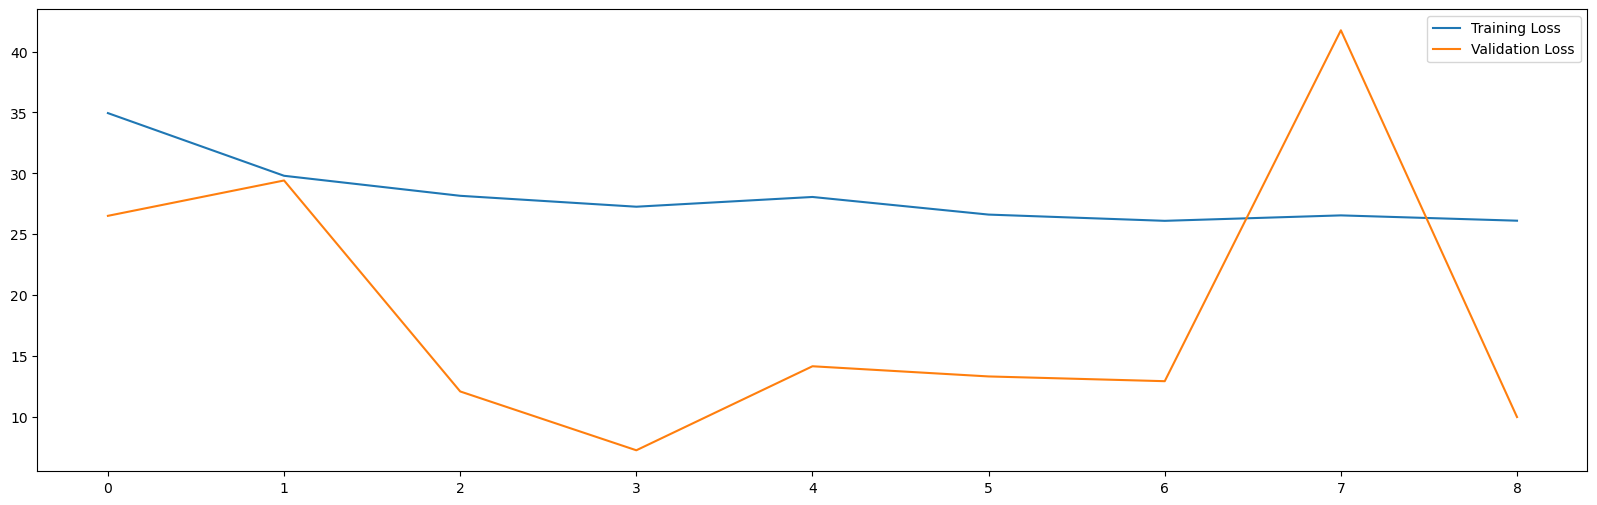

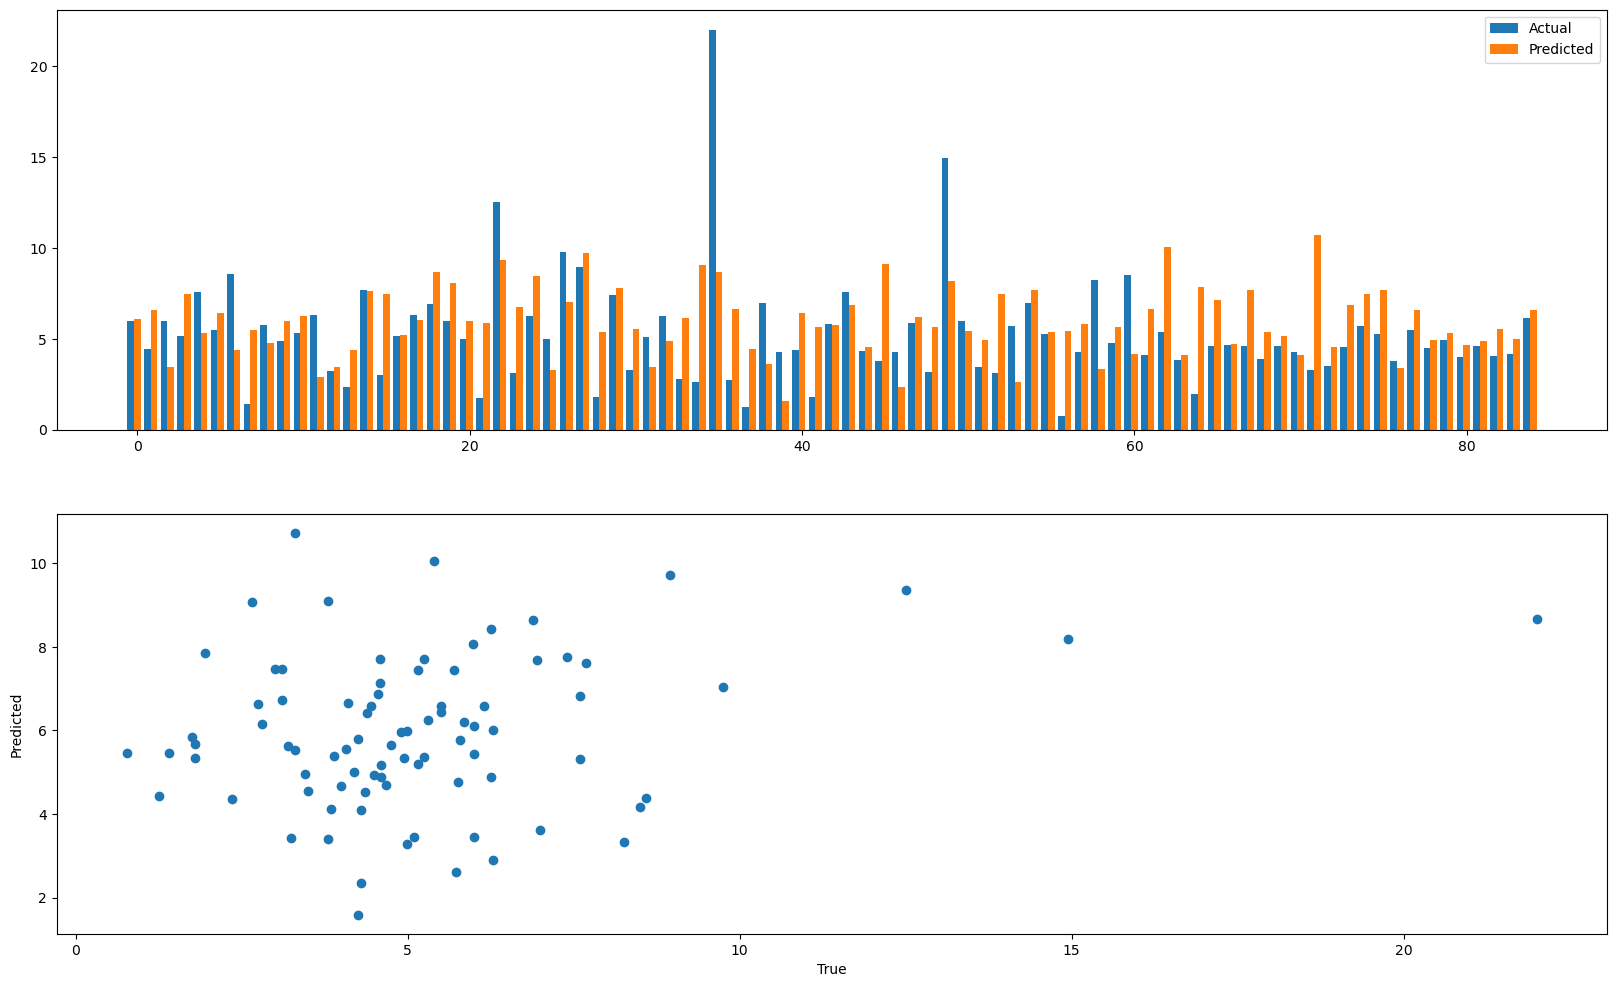

In [85]:
eval(model_cnn_no_aug, history.history, test, test_y)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


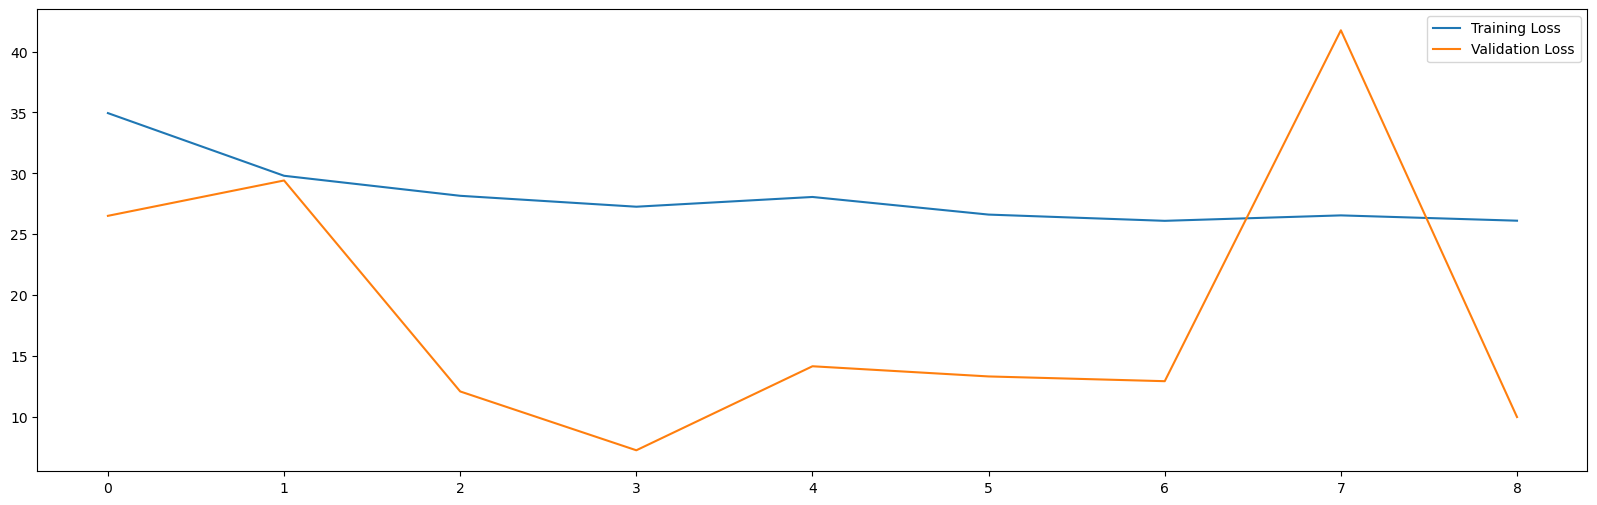

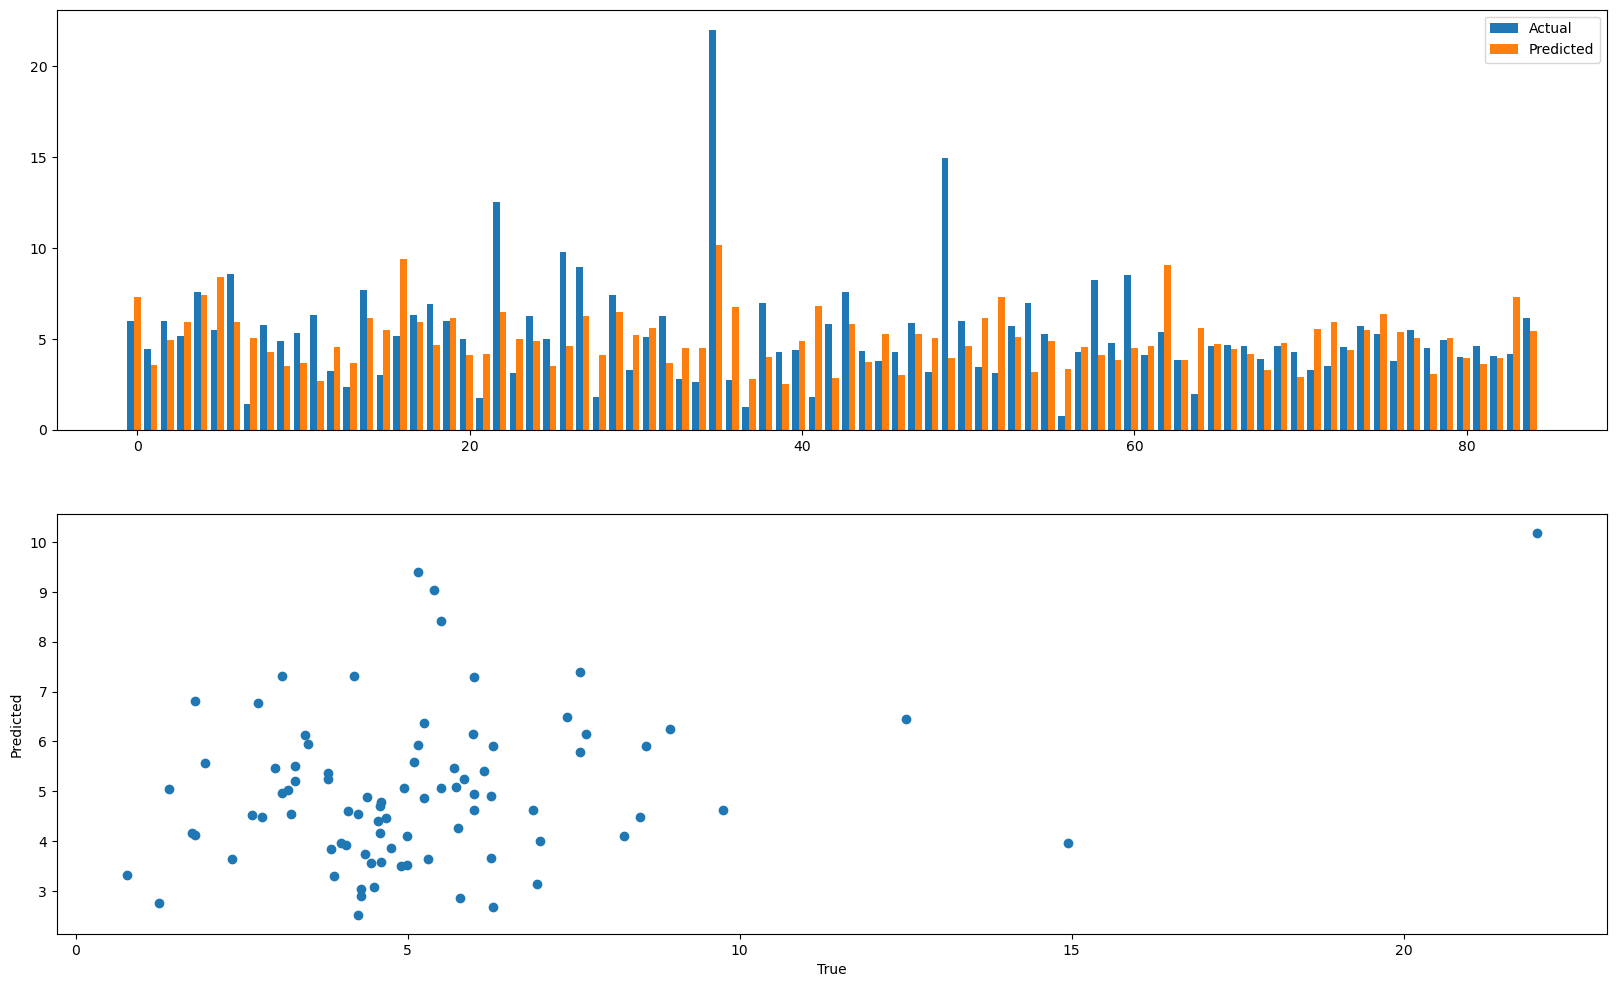

In [86]:
eval(model_cnn_aug, history.history, test, test_y)